<a href="https://colab.research.google.com/github/pran9803/TrafficPredictor/blob/main/Traffic_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##TRAFFIC PREDICTOR

###Importing Modules

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

###Data Loading

In [ ]:
url='https://raw.githubusercontent.com/pran9803/TrafficPredictor/main/traffic.csv?token=GHSAT0AAAAAACMO2V45LHARPFO3UBS2S55GZRAEAGQ'
data = pd.read_csv(url)
data.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


###Data Preprocessing

####Extracting Features

In [ ]:
data['DateTime'] = pd.to_datetime(data['DateTime'])
# Extract and assign components of the datetime to new columns
data['Year'] = data['DateTime'].dt.year
data['Month'] = data['DateTime'].dt.month
data['DayOfMonth'] = data['DateTime'].dt.day
data['Hour'] = data['DateTime'].dt.hour
data['Minute'] = data['DateTime'].dt.minute
data['Second'] = data['DateTime'].dt.second
data['WeekDay'] = data['DateTime'].dt.weekday + 1 # Monday is assigned 1, Tue 2 and so on..

data.head()


,DateTime,Junction,Vehicles,ID,Year,Month,DayOfMonth,Hour,Minute,Second,WeekDay
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,0,0,0,7
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,1,0,0,7
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,2,0,0,7
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,3,0,0,7
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,4,0,0,7


#### Dropping Insignificant Features

In [ ]:
# Drop ID because it is just for identification purpose and not of use in prediction
# Drop Datetime as we split Date, day, hr, second into different columns
# Drop Minute,Second as it is always 0 because the data is collected at every hour
data = data.drop(['ID', 'DateTime', 'Minute', 'Second'], axis=1)


# Display the first few rows of the dataframe to verify the changes
data.head()


,Junction,Vehicles,Year,Month,DayOfMonth,Hour,WeekDay
0,1,15,2015,11,1,0,7
1,1,13,2015,11,1,1,7
2,1,10,2015,11,1,2,7
3,1,7,2015,11,1,3,7
4,1,9,2015,11,1,4,7


In [ ]:
#checking for missing values
print(data.isna().sum()/data.shape[0]*100)


Junction      0.0
Vehicles      0.0
Year          0.0
Month         0.0
DayOfMonth    0.0
Hour          0.0
WeekDay       0.0
dtype: float64


####Data Visualization

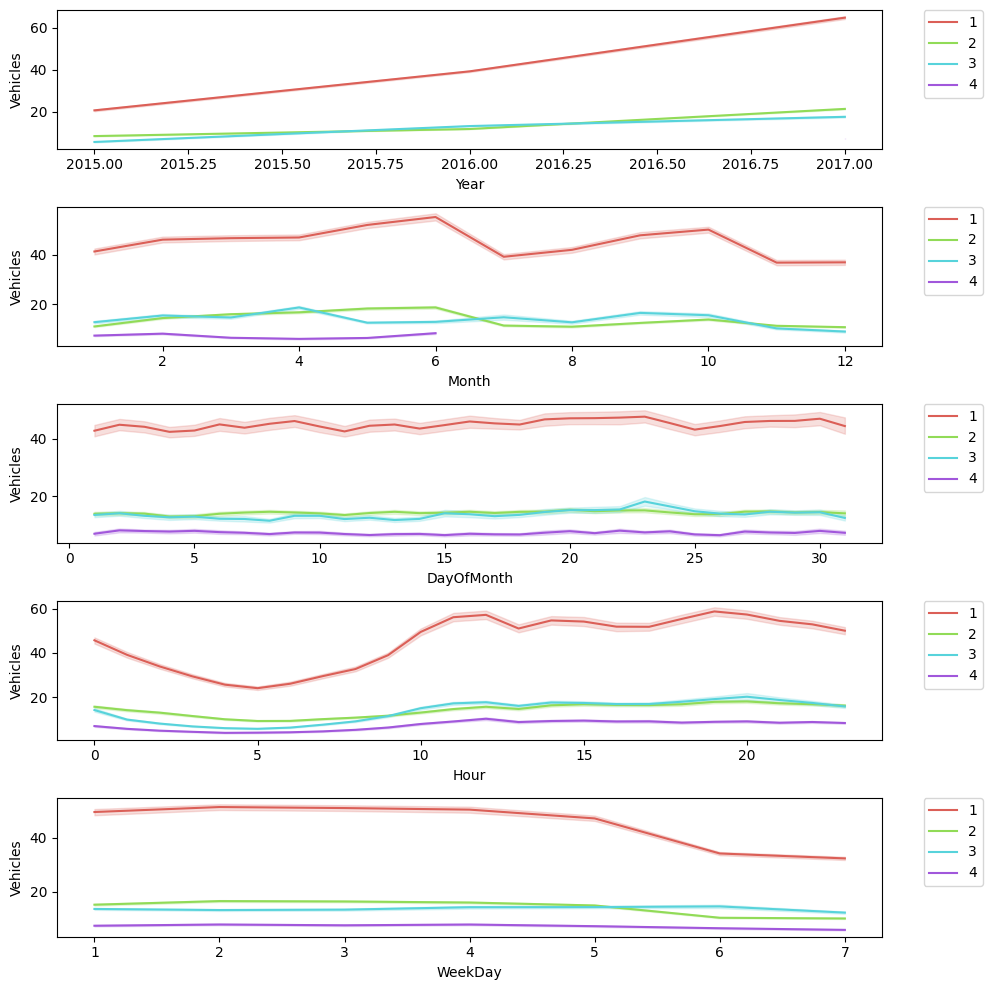

In [ ]:
new_features = ["Year", "Month", "DayOfMonth", "Hour", "WeekDay"]
colors = sns.color_palette("hls", n_colors=len(data["Junction"].unique()))

fig, axes = plt.subplots(len(new_features), 1, figsize=(10, len(new_features) * 2))

for i, feature in enumerate(new_features):
    ax = sns.lineplot(x=data[feature], y="Vehicles", data=data, hue="Junction", palette=colors, ax=axes[i])
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()


Text(0.5, 0, 'Date')

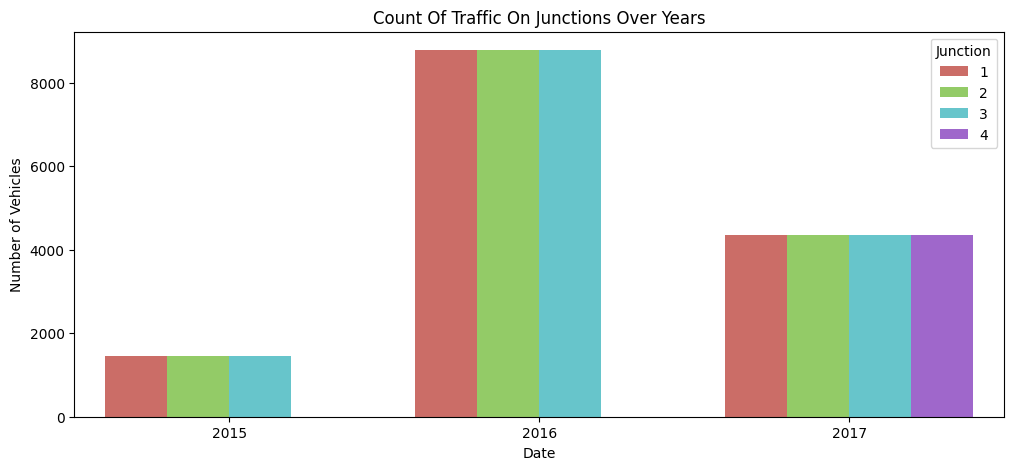

In [ ]:
plt.figure(figsize=(12,5))
count = sns.countplot(data=data, x =data["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")


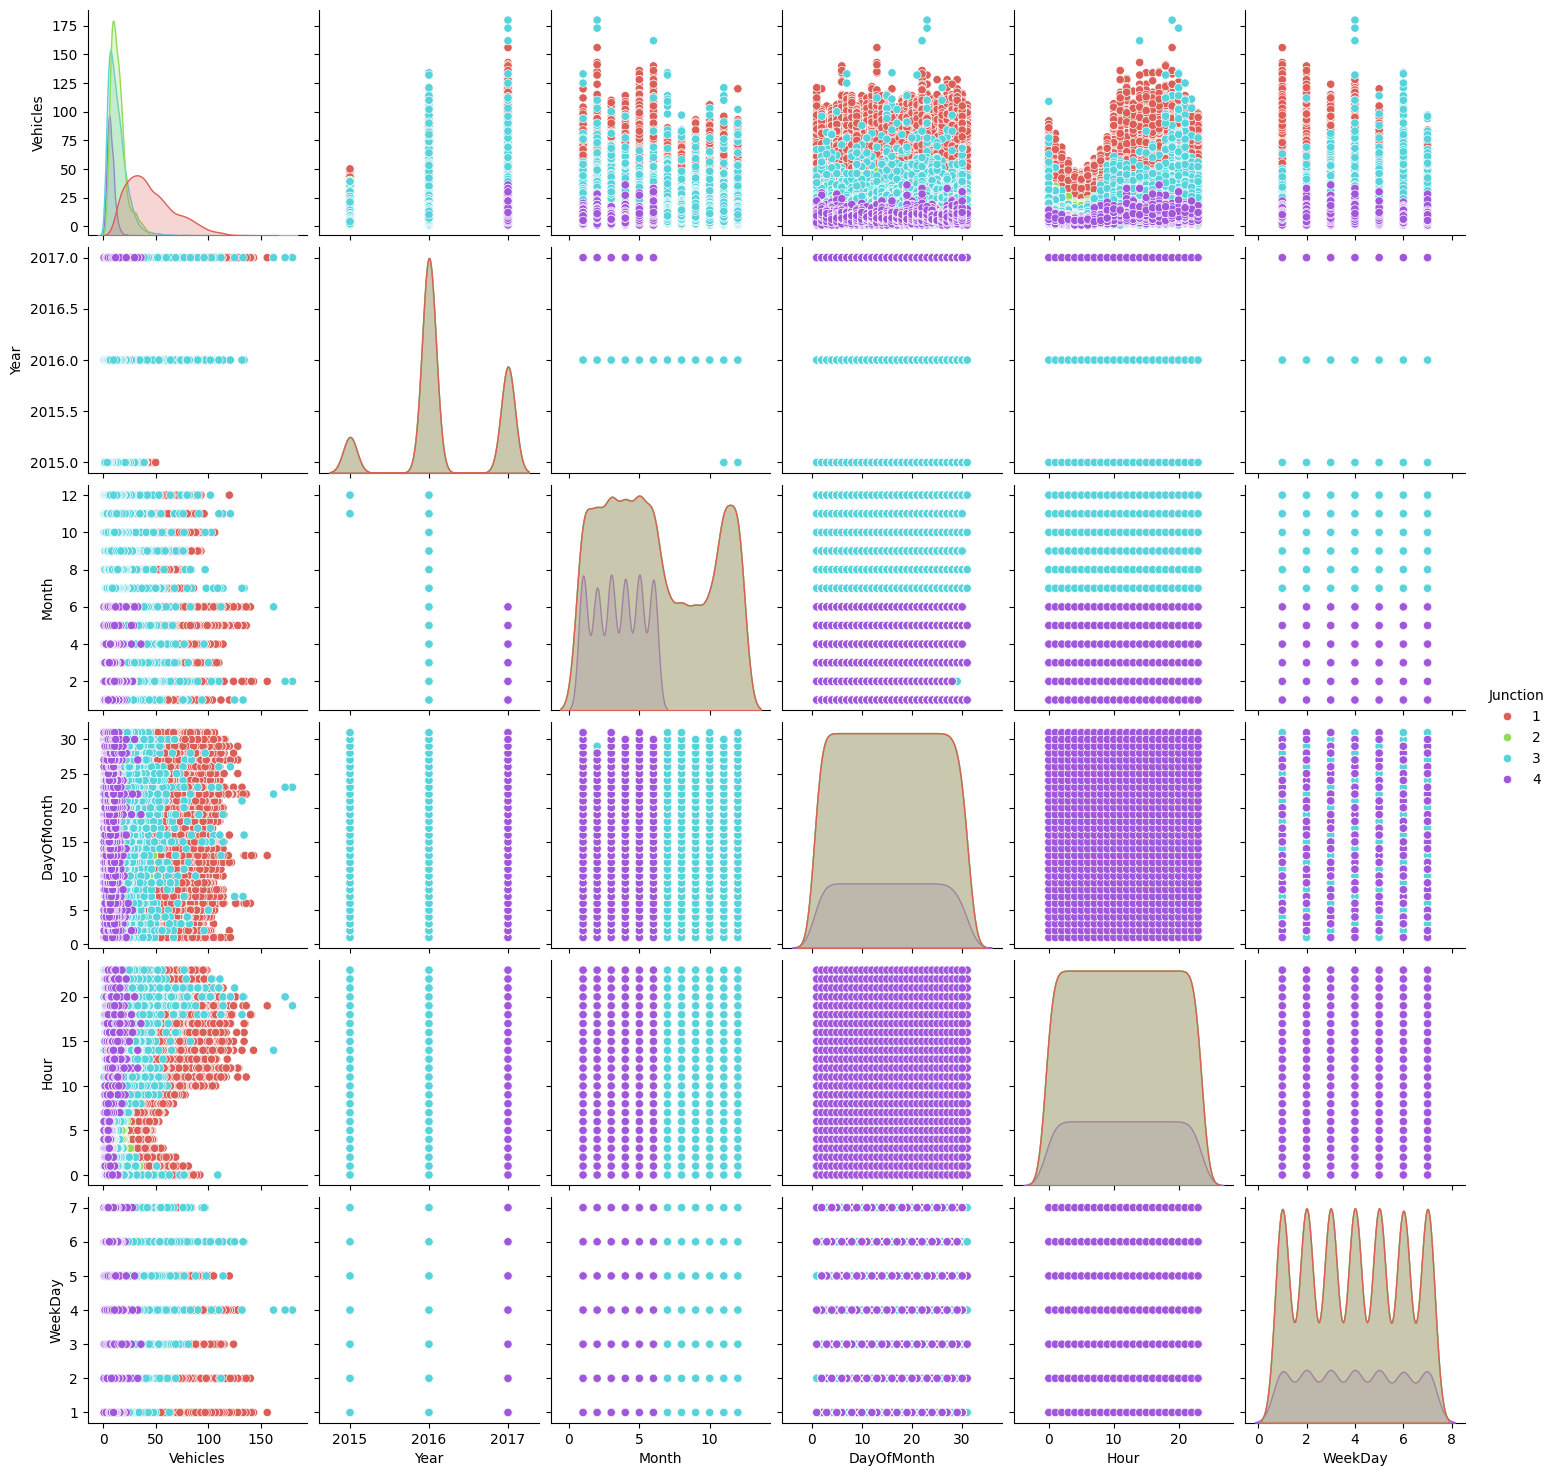

In [ ]:
sns.pairplot(data=data, hue= "Junction",palette=colors)


####Splitting the Dataset

In [ ]:
# Splitting the data into features (X) and No. of vehicles (y)
X = data.drop('Vehicles', axis=1)
y = data['Vehicles']

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=74)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



###Linear Regression

In [ ]:
# Linear regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Prediction on test set
y_pred = lr_model.predict(X_test_scaled)


mse_lr = mean_squared_error(y_test, y_pred)
rmse_lr = mean_squared_error(y_test, y_pred, squared=False)  # Calculate RMSE
mae_lr = mean_absolute_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)

print("Linear regression Model Metrics:")
print("Mean Squared Error:", mse_lr)
print("Root Mean Squared Error:", rmse_lr)
print("Mean Absolute Error:", mae_lr)
print("R-squared Score:", r2_lr)


Linear regression Model Metrics:
Mean Squared Error: 175.4272217826185
Root Mean Squared Error: 13.244894177856557
Mean Absolute Error: 9.693427283728223
R-squared Score: 0.5929050899107802


###KNN Regressor

In [ ]:
# Define the parameter grid for KNN
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric
}

# Initialize KNN model
knn_model = KNeighborsRegressor()

# Initialize GridSearchCV for KNN
grid_search_knn = GridSearchCV(estimator=knn_model, param_grid=knn_param_grid, cv=5, scoring='r2')

# Fit GridSearchCV to find the best parameters for KNN
grid_search_knn.fit(X_train_scaled, y_train)

# Get the best parameters for KNN
best_params_knn = grid_search_knn.best_params_
print("Best Parameters for KNN:", best_params_knn)

# Use the best parameters to initialize KNN model
best_knn_model = KNeighborsRegressor(**best_params_knn)

# Fit the model
best_knn_model.fit(X_train_scaled, y_train)

# Predicting the target values using the best model
y_pred_knn = best_knn_model.predict(X_test_scaled)

# Evaluating the best model
mse_knn_best = mean_squared_error(y_test, y_pred_knn)
rmse_knn_best = mean_squared_error(y_test, y_pred_knn, squared=False)  # Calculate RMSE
mae_knn_best = mean_absolute_error(y_test, y_pred_knn)
r2_knn_best = r2_score(y_test, y_pred_knn)

print("KNN Model Metrics with Best Parameters:")
print("Mean Squared Error:", mse_knn_best)
print("Root Mean Squared Error:", rmse_knn_best)
print("Mean Absolute Error:", mae_knn_best)
print("R-squared Score:", r2_knn_best)


Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
KNN Model Metrics with Best Parameters:
Mean Squared Error: 22.541030273688104
Root Mean Squared Error: 4.747739490924929
Mean Absolute Error: 2.853928170853458
R-squared Score: 0.9476914779853474


###Decision Tree Regressor

In [ ]:
# Initialize Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=74)

# Fit the model
dt_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred_dt = dt_model.predict(X_test_scaled)

# Evaluate the model
mse_dt = mean_squared_error(y_test, y_pred_dt)
rmse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)  # Calculate RMSE
mae_dt = mean_absolute_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print("Decision Tree Model Metrics:")
print("Mean Squared Error:", mse_dt)
print("Root Mean Squared Error:", rmse_dt)
print("Mean Absolute Error:", mae_dt)
print("R-squared Score:", r2_dt)


Decision Tree Model Metrics:
Mean Squared Error: 23.83343724023275
Root Mean Squared Error: 4.881950147249841
Mean Absolute Error: 3.149522028262677
R-squared Score: 0.9446923294353229


###Gradient Boosting

In [ ]:
# Define the parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 4, 5]  # Maximum depth of the individual regression estimators
}

# Initialize Gradient Boosting model
gb_model = GradientBoostingRegressor(random_state=74)

# Initialize GridSearchCV for Gradient Boosting
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid, cv=5, scoring='r2')

# Fit GridSearchCV to find the best parameters for Gradient Boosting
grid_search_gb.fit(X_train_scaled, y_train)

# Get the best parameters for Gradient Boosting
best_params_gb = grid_search_gb.best_params_
print("Best Parameters for Gradient Boosting:", best_params_gb)

# Use the best parameters to initialize the Gradient Boosting model
best_gb_model = GradientBoostingRegressor(**best_params_gb, random_state=74)

# Fit the model using the training data
best_gb_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_gb = best_gb_model.predict(X_test_scaled)

# Evaluate the model
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = mean_squared_error(y_test, y_pred_gb, squared=False)  # Calculate RMSE
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Gradient Boosting Model Metrics with Best Parameters:")
print("Mean Squared Error:", mse_gb)
print("Root Mean Squared Error:", rmse_gb)
print("Mean Absolute Error:", mae_gb)
print("R-squared Score:", r2_gb)


Best Parameters for Gradient Boosting: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Gradient Boosting Model Metrics with Best Parameters:
Mean Squared Error: 25.6328426334719
Root Mean Squared Error: 5.062888763687377
Mean Absolute Error: 2.737564338089023
R-squared Score: 0.9405166446736816


###Random Forest

In [ ]:
# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=74)

# Fit the model using the training data
rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test_scaled)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)  # Calculate RMSE
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Model Metrics:")
print("Mean Squared Error:", mse_rf)
print("Root Mean Squared Error:", rmse_rf)
print("Mean Absolute Error:", mae_rf)
print("R-squared Score:", r2_rf)


Random Forest Model Metrics:
Mean Squared Error: 16.750267248545303
Root Mean Squared Error: 4.092709035412279
Mean Absolute Error: 2.4334663341645886
R-squared Score: 0.961129473121528


In [ ]:

# Define the parameter distribution for Random Forest
rf_param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees in the forest
    'max_depth': [None] + list(randint(1, 50).rvs(10)),  # Maximum depth of the tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split a node
    'min_samples_leaf': randint(1, 20)  # Minimum number of samples required at each leaf node
}

# Initialize Random Forest model
rf_model = RandomForestRegressor(random_state=74)

# Initialize RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_dist, n_iter=100, cv=5, scoring='r2', random_state=74)

# Fit RandomizedSearchCV to find the best parameters for Random Forest
random_search_rf.fit(X_train_scaled, y_train)

# Get the best parameters for Random Forest
best_params_rf = random_search_rf.best_params_
print("Best Parameters for Random Forest:", best_params_rf)

# Use the best parameters to initialize the Random Forest model
best_rf_model = RandomForestRegressor(**best_params_rf, random_state=74)

# Fit the model using the training data
best_rf_model.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred_rf = best_rf_model.predict(X_test_scaled)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)  # Calculate RMSE
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Model Metrics with Best Parameters (Randomized Search):")
print("Mean Squared Error:", mse_rf)
print("Root Mean Squared Error:", rmse_rf)
print("Mean Absolute Error:", mae_rf)
print("R-squared Score:", r2_rf)


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 228}
Random Forest Model Metrics with Best Parameters (Randomized Search):
Mean Squared Error: 18.477167281748706
Root Mean Squared Error: 4.298507564463358
Mean Absolute Error: 2.4633395761467227
R-squared Score: 0.9571220436781024


###R-Squared Scores

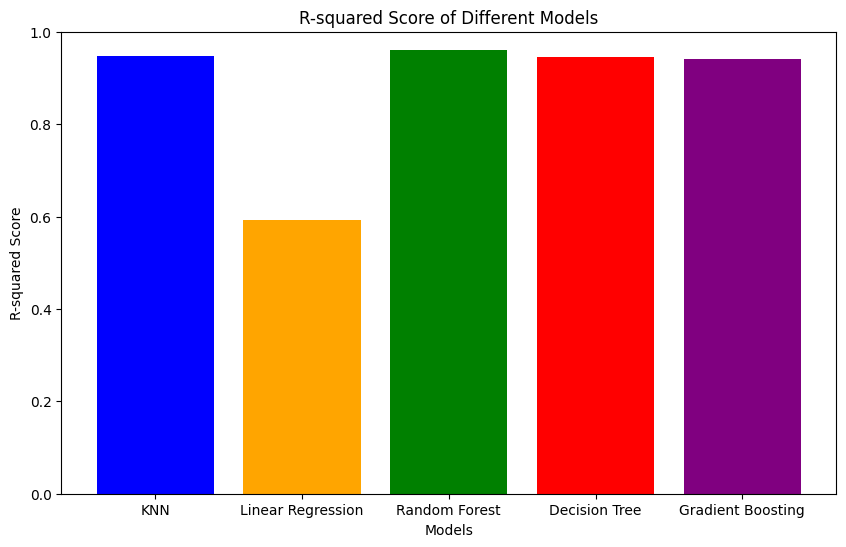

In [ ]:
# Model names and their R-squared scores
models = ['KNN', 'Linear Regression', 'Random Forest', 'Decision Tree', 'Gradient Boosting']
r2_scores = [r2_knn_best, r2_lr, r2_rf, r2_dt, r2_gb]

# Plotting the R-squared scores
plt.figure(figsize=(10, 6))
plt.bar(models, r2_scores, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Models')
plt.ylabel('R-squared Score')
plt.title('R-squared Score of Different Models')
plt.ylim(0, 1)  # Limiting y-axis from 0 to 1
plt.show()
